In [1]:
#!/usr/bin/env python
# -*- coding: utf-12-*-


# Deep Neural Networks

## Lecture 24
### Neural Network with :

- **Flower Dataset**
- multiple hidden layer 
- ${Relu}$ activation function
- **multi-class**

<img src='../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
!pip install torchsummary

In [3]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections.abc import Callable
from typing import Literal

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

# Changes-----------------------------------
import torch
import torch.nn as nn
import torch.nn as nn  
import torch.nn.functional as F
from torch.autograd import Variable
# Changes-----------------------------------
from torch.utils.data import DataLoader, Dataset

from torchsummary import summary
from torchvision import transforms, datasets

%matplotlib inline

In [4]:
###----------------
### Some parameters
###----------------

inpDir = '../../input'
outDir = '../output'
subDir = 'flower_photos'

RANDOM_STATE = 24 # REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 100 # number of epochs
ALPHA = 0.001 # learning rate
NUM_SAMPLES = 1280 # How many samples we want to generate 
NOISE = 0.2 # Noise to be introduced in the data
TEST_SIZE = 0.2
BATCH_SIZE = 32

#INPUT image size 
IMG_HEIGHT = 188
IMG_WIDTH=188
NumChannels = 188

#for early stopping
PATIENCE = 20
LR_FACTOR = 0.8
LR_PATIENCE = 10

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

CMAP = 'coolwarm' # plt.cm.Spectral

plt.rcParams.update(params)

## Helper Functions

## Read Data Set


In [5]:
data_dir = 'flower_photos'


In [6]:
#transformation

transform = transforms.Compose([
    transforms.Resize(IMG_HEIGHT),
    transforms.CenterCrop(IMG_HEIGHT),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.485, 0.456, 0.486],
        std = [0.229, 0.224, 0.225]
    )
]
)

dataset = datasets.ImageFolder(data_dir, transform=transform)

In [7]:
image, label = next(iter(dataset))
image.shape, label

(torch.Size([3, 188, 188]), 0)

In [8]:
dataset_size = len(dataset)

test_size = int(TEST_SIZE * dataset_size)

print(dataset_size, test_size)

3670 734


In [9]:
indices = torch.randperm(len(dataset)).tolist()

#indices

#pick up indices upto test_size
train_dataset = torch.utils.data.Subset(dataset,indices[:-test_size])
#pick up indices from test_size
test_dataset = torch.utils.data.Subset(dataset,indices[-test_size:])


In [10]:
class_names = train_dataset.dataset.classes
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [11]:
numClasses = len(class_names)
numClasses

5

In [12]:
next(iter(train_dataset))[0].shape

torch.Size([3, 188, 188])

In [13]:
# torch.utils.data.DataLoader?

# Data Loader

In [14]:
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size = BATCH_SIZE, 
                                               shuffle= True)
test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                               batch_size = BATCH_SIZE, 
                                               shuffle= True)

trainSteps = len(train_dataloader.dataset)//BATCH_SIZE

testSteps = len(test_dataloader.dataset)//BATCH_SIZE

print(trainSteps, testSteps)


91 22


In [15]:
def fn_showImages(img, ax):
    
    img = img.numpy().transpose((1, 2, 0))
    
    means = np.array([0.485, 0.456, 0.486])
    stds = np.array([0.229, 0.224, 0.225])
    img = stds*img+means
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    
    

In [16]:
torch.__version__

'2.1.1+cu121'

torch.Size([32, 3, 188, 188]) torch.Size([32])


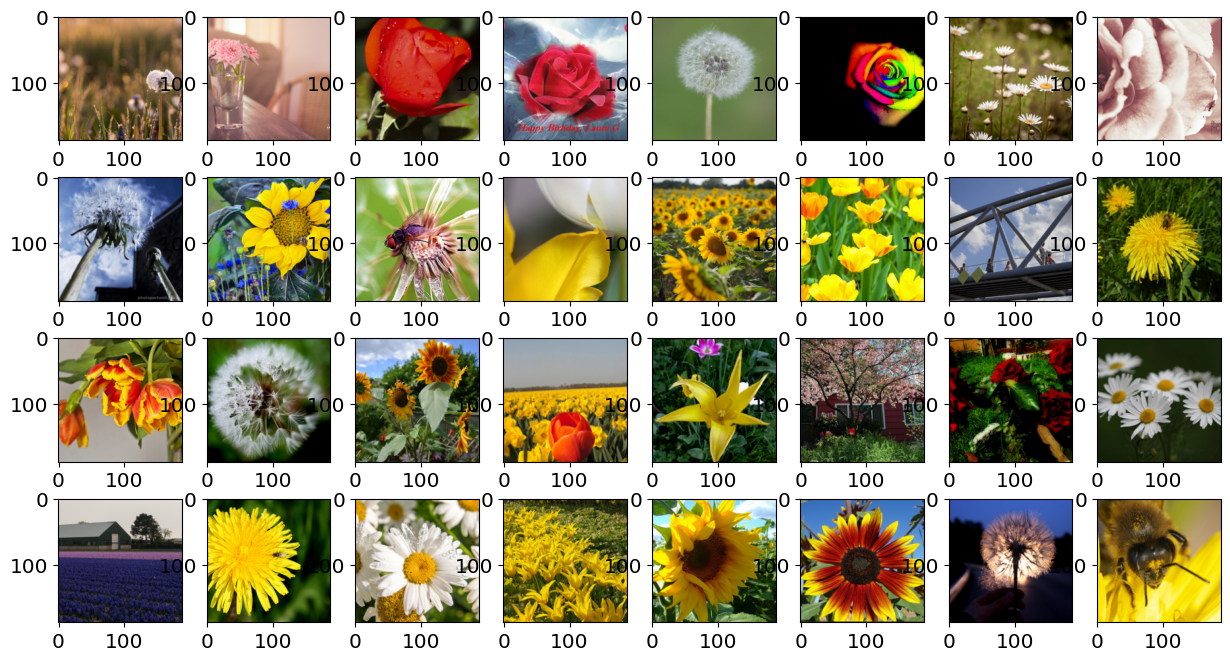

In [17]:
images, labels = next(iter(train_dataloader))
print(images.shape, labels.shape)

fig = plt.figure(figsize=(15,8))

for i in range(BATCH_SIZE):
    ax = fig.add_subplot(BATCH_SIZE//8, 8, i+1)
    fn_showImages(images[i], ax)

# CNN Model

In [18]:
outChannels1 = 64
outChannels2 = 128
outChannels3 = 256
outChannels4 = 512
outChannels5 = 512
outChannels6 = 1024
drop_out_rate=0.5
numChannels=3

model = nn.Sequential(
    
    #set 1
    nn.Conv2d(in_channels=numChannels, out_channels=outChannels1, 
              kernel_size = (3,3), 
              padding='same'), # 188 X 188 X 64
    
    nn.ReLU(),
    
    nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)), # 94 X 94 X 64
    
    #set2
    nn.Conv2d(in_channels=outChannels1, out_channels=outChannels2, 
              kernel_size = (3,3)), # 92 X 92 X 128
    
    nn.ReLU(),
    
    nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)) ,# 46 X 46 X 128
    
    #set3
    nn.Conv2d(in_channels=outChannels2, out_channels=outChannels3, 
              kernel_size = (3,3)), # 44 X 44 X 256
    
    
    nn.ReLU(),
    
    nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)) ,# 22 X 22 X 256
    
    #set4
    nn.Conv2d(in_channels=outChannels3, out_channels=outChannels4, 
              kernel_size = (3,3)), # 20 X 20 X 512
    nn.BatchNorm2d(outChannels4),
    nn.ReLU(),
    
    nn.Dropout(drop_out_rate),
    nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)) ,# 10 X 10 X 512
    
    
    #set5
    nn.Conv2d(in_channels=outChannels4, out_channels=outChannels5, 
              kernel_size = (3,3)), # 8 X 8 X 512
    
    nn.ReLU(),
    
    nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)), # 4 X 4 X 512
    
    #set6
    nn.Conv2d(in_channels=outChannels5, out_channels=outChannels6, 
              kernel_size = (3,3)), # 2 X 2 X 1024
    
    nn. ReLU(),
    
    nn.Flatten(),
    
    nn.Linear(in_features  = 2 * 2 * outChannels6, out_features=outChannels6),
    
    nn. ReLU(),
    
    nn.Linear(in_features  = outChannels6, out_features=numClasses)
    
    
)


In [19]:
#torch.cuda.current_device()

In [20]:
#torch.cuda.get_device_name(torch.cuda.current_device())

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [22]:
model = model.to(device)
print(model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Dropout(p=0.5, inplace=False)
  (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
  (15): ReLU()
  (16): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(512, 1

# Loss Function

In [23]:
loss_fn = nn.CrossEntropyLoss()


loss, tloss = [],[]
acc, tacc = [],[]
n_epoch = []


optimizer = torch.optim.Adam(model.parameters(), lr = ALPHA)

# Train the model for multiple epochs
for epoch in range (EPOCHS):
    
    # Training loop
    train_loss = 0.0
    train_acc = 0.0
    
    for data in train_dataloader:
        
        X_train, y_train = data
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        
        optimizer.zero_grad()
        
        model.train() # Set the model in training mode
    
        outputs = model(X_train)
        y_pred = torch.argmax(outputs, dim = 1)
        
        batch_loss = loss_fn(outputs, y_train)
        batch_acc = accuracy_score(y_train.cpu().numpy(), y_pred.cpu().numpy())

        # Back prop
        optimizer.zero_grad()

        batch_loss.backward()

        optimizer.step()
        
        train_loss += batch_loss.item() * X_train.size(0)
        train_acc += batch_acc * X_train.size(0)
    
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    
    loss.append(train_loss)
    acc.append(train_acc)
    
    # Testing loop
    test_loss = 0.0
    test_acc = 0.0
    
    with torch.no_grad():
        
        model.eval() # evaluation mode
    
        for data in test_dataloader:
            
            X_test, y_test = data
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            
            outputs = model(X_test)
            y_pred = torch.argmax(outputs, dim = 1)
            
            batch_loss = loss_fn(outputs, y_test)
            batch_acc = accuracy_score(y_test.cpu().numpy(), y_pred.cpu().numpy())
            
            test_loss += batch_loss.item() * X_test.size(0)
            test_acc += batch_acc* X_test.size(0)
        
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
    
        tloss.append(test_loss)
        tacc.append(test_acc)
    
    n_epoch.append(epoch)
    
    if epoch%10 == 0:
        print(f'At epoch {epoch} | Loss - train:{train_loss:.4f}, test:{test_loss:.4f} | Acc - train:{train_acc:.4f}, test:{test_acc:.4f}')

At epoch 0 | Loss - train:55.5115, test:44.2321 | Acc - train:9.6304, test:12.9565


KeyboardInterrupt: 

In [ ]:
loss_df = pd.DataFrame({'epoch': n_epoch, 
                        'loss': loss, 
                        'test loss': tloss,
                        'acc': acc, 
                        'test acc': tacc
                       })

In [ ]:
loss_df.plot(x = 'epoch', y = ['loss', 'test loss']);

In [ ]:
loss_df.plot(x = 'epoch', y = ['acc', 'test acc']);